In [1]:
import jax
import jax.numpy as jnp

import optax
import jaxopt

import matplotlib.pyplot as plt

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

from gpax import ExactGP, SparseGP, RBFKernel, HomoscedasticNoise, ConstantMean
from gpax.utils import constrain, unconstrain, randomize, train_fn
from gpax.plotting import plot_posterior

import lab.jax as B

import pprint
pp = pprint.PrettyPrinter(depth=4)

(100, 1) (100,)


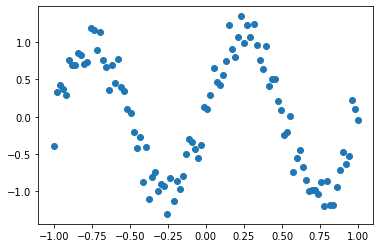

In [2]:
X = jnp.linspace(-1, 1, 100).reshape(-1, 1)
# X = jnp.concatenate([X[:40], X[60:]])
key = jax.random.PRNGKey(0)
y = jnp.sin(2 * jnp.pi * X) + jax.random.normal(key, X.shape)*0.2
y = y.ravel()

plt.scatter(X, y);
print(X.shape, y.shape)

## Exact GP

In [3]:
model = ExactGP(kernel=RBFKernel(), 
                noise=HomoscedasticNoise(), 
                mean=ConstantMean())

def loss_fun(params):
    return -model.log_probability(params, X, y)

key = jax.random.PRNGKey(123)
params = model.initialise_params(key, X)
pp.pprint(params)

{'kernel': {'lengthscale': DeviceArray([1.], dtype=float32, weak_type=True),
            'variance': DeviceArray(1., dtype=float32, weak_type=True)},
 'mean': {'value': DeviceArray(0., dtype=float32, weak_type=True)},
 'noise': {'variance': DeviceArray(1., dtype=float32, weak_type=True)}}


In [4]:
bijectors = model.get_bijectors()
pp.pprint(bijectors)

{'kernel': {'lengthscale': <tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
            'variance': <tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>},
 'mean': {'value': <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>},
 'noise': {'variance': <tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>}}


In [5]:
params = model.initialise_params(key, X)
jax.grad(loss_fun)(params)

{'kernel': {'lengthscale': DeviceArray([2.8335695], dtype=float32, weak_type=True),
  'variance': DeviceArray(0.3629837, dtype=float32, weak_type=True)},
 'mean': {'value': DeviceArray(0.04458046, dtype=float32, weak_type=True)},
 'noise': {'variance': DeviceArray(24.837248, dtype=float32, weak_type=True)}}

In [6]:
optimizer = optax.adam(1e-1)
num_epochs = 100

params = model.initialise_params(key, X)
params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(7)
params = randomize(params, key)

result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

# lbfgs_loss_fn = lambda params: loss_fun(constrain(params, bijectors))
# optimizer = jaxopt.ScipyMinimize(fun=lbfgs_loss_fn, method='L-BFGS-B')
# result = {}
# result["params"] = optimizer.run(params).params

# plt.plot(result["loss_history"]);

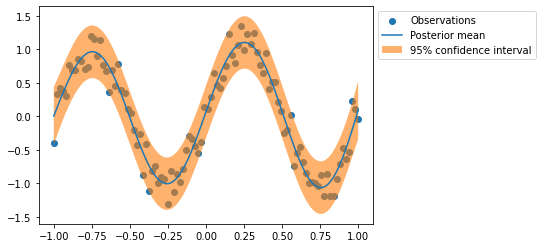

In [7]:
X_test = jnp.linspace(-1, 1, 200).reshape(-1, 1)
params = constrain(result["params"], bijectors)

ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6);
ax.legend(bbox_to_anchor=(1,1));

## Sparse GP

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/plum/function.py:592: ToDenseWarning: Solving <lower-triangular matrix: batch=(), shape=(10, 10), dtype=float64> x = <upper-triangular matrix: batch=(), shape=(10, 10), dtype=float64>: converting to dense.
  return _convert(method(*args, **kw_args), return_type)


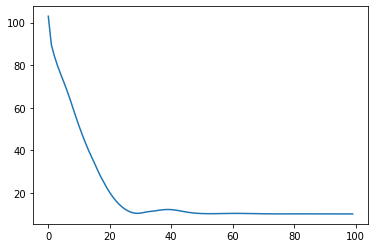

In [8]:
X_inducing = X[40:50]
model = SparseGP(
    kernel=RBFKernel(),
    noise=HomoscedasticNoise(),
    mean=ConstantMean(),
    method="vfe", # "vfe" or "fitc" or "dtc"
)


def loss_fun(params):
    return -model.elbo(params, X, y)

key = jax.random.PRNGKey(123)
params = model.initialise_params(key, X, X_inducing)
bijectors = model.get_bijectors()

optimizer = optax.adam(1e-1)
num_epochs = 100

params = unconstrain(params, bijectors)
params = randomize(params, key)
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

plt.plot(result["loss_history"]);

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/plum/function.py:584: ToDenseWarning: Solving <lower-triangular matrix: batch=(), shape=(10, 10), dtype=float64> x = <upper-triangular matrix: batch=(), shape=(10, 10), dtype=float64>: converting to dense.
  return method(*args, **kw_args)


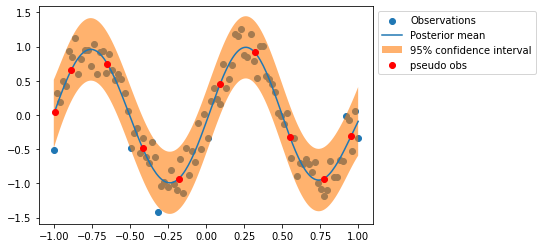

In [9]:
params = constrain(result["params"], bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6)
f = model.get_gp(params)
pseudo_obs = model.get_pseudo_obs(params, f, X, y)
ax.plot(params['X_inducing'], B.dense(pseudo_obs.mu(f.measure)), 'o', color='red', label='pseudo obs');
ax.legend(bbox_to_anchor=(1,1));